# ALE/Pong-v5 Environment Dependencies

In [7]:
pip install gymnasium[atari] ale-py


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 51.8 MB/s eta 0:00:00


In [8]:
import gymnasium as gym
print(gym.envs.registry.keys())


dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v3', 'LunarLanderContinuous-v3', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v3', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Reacher-v5', 'Pusher-v2', 'Pusher-v4', 'Pusher-v5', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'HalfCheetah-v5', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Hopper-v5', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Swimmer-v5', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Walker2d-v5', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'Humanoid-v5

In [9]:
import ale_py
print(ale_py.__version__)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.10.1


In [10]:
pip install --upgrade gymnasium[atari]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Part B




In [17]:
import gymnasium as gym

# Create the environment with a render mode of 'rgb_array' (image output)
env = gym.make('ALE/Pong-v5', render_mode='rgb_array')

# Print the state and action space
print("State Space: ", env.observation_space)
print("Action Space: ", env.action_space)

# Initialize the environment and start a random agent interaction
obs, info = env.reset()
done = False
total_reward = 0

# Run the environment with a random agent
while not done:
    # Choose a random action from the action space
    action = env.action_space.sample()

    # Step the environment with the chosen action
    next_obs, reward, done, truncated, info = env.step(action)

    # Accumulate the total reward
    total_reward += reward

    # Optionally, render the environment to get an image (rgb_array)
    frame = env.render()  # 'frame' will be an RGB image (array)

print("Total Reward: ", total_reward)


State Space:  Box(0, 255, (210, 160, 3), uint8)
Action Space:  Discrete(6)
Total Reward:  -20.0


# Part C

In [ ]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import cv2
import gymnasium as gym

from google.colab import drive
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/dqn_checkpoints'

os.makedirs(save_dir, exist_ok=True)

# Set device to CPU (No CUDA)
device = torch.device("cpu")

# Set up the neural network
class DQNNetwork(nn.Module):
    def __init__(self, action_size):
        super(DQNNetwork, self).__init__()
        # Reduced complexity of the network
        self.conv1 = nn.Conv2d(4, 16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.fc1 = nn.Linear(32 * 9 * 9, 256)  # Reduced layer size
        self.fc2 = nn.Linear(256, action_size)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Preprocess frames - Reduced preprocessing time
def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Grayscale
    frame = cv2.resize(frame, (84, 84))  # Resize to 84x84
    return frame

# Stack frames to create a state
def stack_frames(frames, state):
    state[:-1] = state[1:]
    state[-1] = frames
    return state

# Hyperparameters
state_size = (84, 84, 4)
env = gym.make('ALE/Pong-v5')  # Change the environment as needed
action_size = env.action_space.n
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate
epsilon_min = 0.1
epsilon_decay = 0.995
batch_size = 8  # Increased batch size
memory = deque(maxlen=2000)
target_update_interval = 10
episodes = 1000

# Initialize networks and optimizer
model = DQNNetwork(action_size).to(device)
target_model = DQNNetwork(action_size).to(device)
target_model.load_state_dict(model.state_dict())
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Experience replay buffer
def store_experience(memory, state, action, reward, next_state, done):
    memory.append((
        torch.tensor(state, dtype=torch.float32).to(device),
        action,
        reward,
        torch.tensor(next_state, dtype=torch.float32).to(device),
        done
    ))

def sample_experiences(memory, batch_size):
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    return (
        torch.stack(states),  # Faster than array conversion
        torch.tensor(actions, dtype=torch.int64),
        torch.tensor(rewards, dtype=torch.float32),
        torch.stack(next_states),
        torch.tensor(dones, dtype=torch.float32)
    )

# Choose action with epsilon-greedy policy
def choose_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()
    else:
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state)
        return torch.argmax(q_values).item()

# Train the DQN model
def train_step():
    if len(memory) < batch_size:
        return

    states, actions, rewards, next_states, dones = sample_experiences(memory, batch_size)
    q_values = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        next_q_values = target_model(next_states).max(1)[0]
        target_q_values = rewards + (gamma * next_q_values * (1 - dones))

    loss = nn.MSELoss()(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Load saved data if exists
start_episode = 0
rewards_history = []

if os.path.exists(os.path.join(save_dir, 'checkpoint.pth')):
    model.load_state_dict(torch.load(os.path.join(save_dir, 'checkpoint.pth'), map_location=device))
    target_model.load_state_dict(model.state_dict())
    with open(os.path.join(save_dir, 'rewards.pkl'), 'rb') as f:
        data = pickle.load(f)
        start_episode = data['episode']
        rewards_history = data['rewards_history']
    print(f"Resuming training from episode {start_episode + 1}...")

rewards_plot = []
# Main training loop
for episode in range(start_episode, episodes):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]

    state = np.array(state)
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=0)
    done = False
    total_reward = 0
    timestep = 0

    while not done:
        action = choose_action(state, epsilon)
        values = env.step(action)
        next_frame, reward, done = values[0], values[1], values[2]
        total_reward += reward

        next_frame = np.array(next_frame)
        next_frame = preprocess_frame(next_frame)
        next_state = stack_frames(next_frame, state)

        store_experience(memory, state, action, reward, next_state, done)
        train_step()

        state = next_state
        timestep += 1

        if timestep % target_update_interval == 0:
            target_model.load_state_dict(model.state_dict())

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    rewards_history.append(total_reward)
    rewards_plot.append(total_reward)
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {epsilon}")

    # Save model and rewards every 5 episodes (optimized for speed)
    if (episode + 1) % 5 == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, 'checkpoint.pth'))
        with open(os.path.join(save_dir, 'rewards.pkl'), 'wb') as f:
            pickle.dump({'episode': episode, 'rewards_history': rewards_history}, f)
        print(f"Checkpoint saved at episode {episode + 1}")

env.close()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Episode: 1, Total Reward: -20.0, Epsilon: 0.995
Episode: 2, Total Reward: -21.0, Epsilon: 0.990025
Episode: 3, Total Reward: -21.0, Epsilon: 0.985074875
Episode: 4, Total Reward: -21.0, Epsilon: 0.9801495006250001
Episode: 5, Total Reward: -21.0, Epsilon: 0.9752487531218751
Checkpoint saved at episode 5
Episode: 6, Total Reward: -21.0, Epsilon: 0.9703725093562657
Episode: 7, Total Reward: -21.0, Epsilon: 0.9655206468094844
Episode: 8, Total Reward: -21.0, Epsilon: 0.960693043575437
Episode: 9, Total Reward: -19.0, Epsilon: 0.9558895783575597
Episode: 10, Total Reward: -20.0, Epsilon: 0.9511101304657719
Checkpoint saved at episode 10
Episode: 11, Total Reward: -21.0, Epsilon: 0.946354579813443
Episode: 12, Total Reward: -21.0, Epsilon: 0.9416228069143757
Episode: 13, Total Reward: -21.0, Epsilon: 0.9369146928798039
Episode: 14, Total Reward: -18.0, Epsilon: 0.

Mounted at /content/drive
Rewards data loaded successfully.


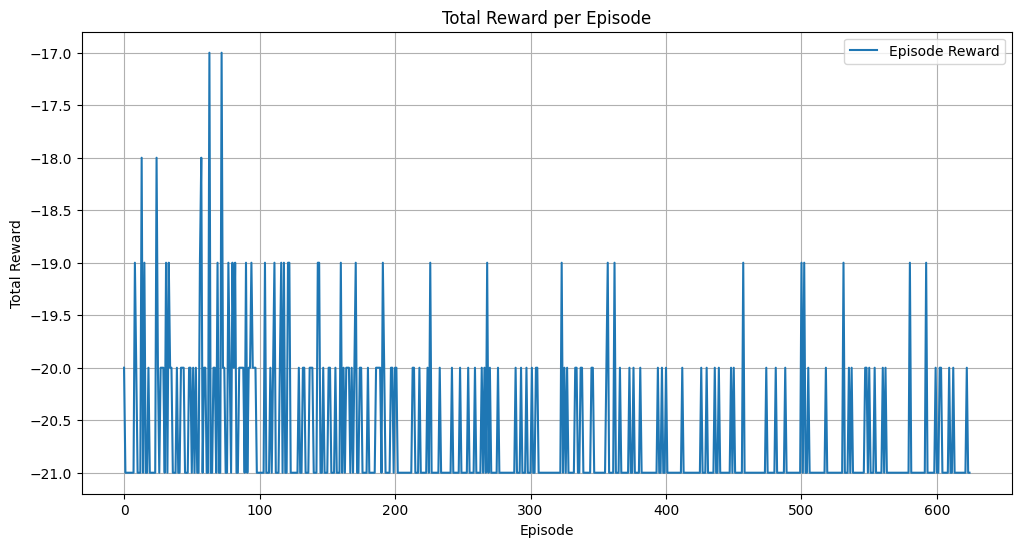

In [5]:
import os  # Make sure to import os at the top
import pickle
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

# Path where you saved the rewards history
save_dir = '/content/drive/MyDrive/dqn_checkpoints'
rewards_plot = []

# Load rewards history from the saved file
try:
    with open(os.path.join(save_dir, 'rewards.pkl'), 'rb') as f:
        data = pickle.load(f)
        rewards_plot = data['rewards_history']
        print("Rewards data loaded successfully.")
except FileNotFoundError:
    print("No saved rewards data found.")

# Plotting the rewards
if rewards_plot:
    plt.figure(figsize=(12, 6))
    plt.plot(rewards_plot, label='Episode Reward')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print("No rewards data to plot.")
